In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [ ]:

# Load the dataset
df = pd.read_csv('bank_data.csv')

In [ ]:
df

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540000,Level 0 Recovery,19,Male
1,1150,486,416.090000,Level 0 Recovery,25,Female
2,380,527,429.350000,Level 0 Recovery,27,Male
3,1838,536,296.990000,Level 0 Recovery,25,Male
4,1995,541,346.385000,Level 0 Recovery,34,Male
...,...,...,...,...,...,...
1877,361,9785,15388.195990,Level 4 Recovery,65,Female
1878,196,9857,9709.909257,Level 4 Recovery,68,Female
1879,313,9859,30209.181790,Level 4 Recovery,58,Female
1880,1781,9920,20386.232190,Level 4 Recovery,67,Female


In [ ]:
# Finding out the net benefit
df['net_benefit']=df['actual_recovery_amount']-df['expected_recovery_amount']

In [ ]:
print(df['net_benefit'])

0          69.540000
1         -69.910000
2         -97.650000
3        -239.010000
4        -194.615000
            ...     
1877     5603.195990
1878     -147.090743
1879    20350.181790
1880    10466.232190
1881     6742.305920
Name: net_benefit, Length: 1882, dtype: float64


Comparing net benefits between adjacent strategy levels to find potential discontinuities

In [ ]:
# Calculating difference in net benefits between levels
df['net_benefit_Diff']=df['net_benefit'].diff()

In [ ]:
# Finding where the difference is greater than $50
discontinuity_points=df[df['net_benefit_Diff']>50]

In [ ]:
# Display the potential discontinuity points
print(discontinuity_points)

        id  expected_recovery_amount  actual_recovery_amount  \
5      731                       548               520.71000   
7     1932                       560               373.72000   
9     2001                       565               504.88500   
12     286                       587               400.36500   
16    1816                       605               444.45500   
...    ...                       ...                     ...   
1868   981                      9474             21446.80990   
1870   607                      9525             20616.21457   
1873  1618                      9621             23794.83265   
1875   461                      9742             28305.00625   
1879   313                      9859             30209.18179   

     recovery_strategy  age     sex  net_benefit  net_benefit_Diff  
5     Level 0 Recovery   35    Male    -27.29000        167.325000  
7     Level 0 Recovery   19  Female   -186.28000        141.135000  
9     Level 0 Recovery  

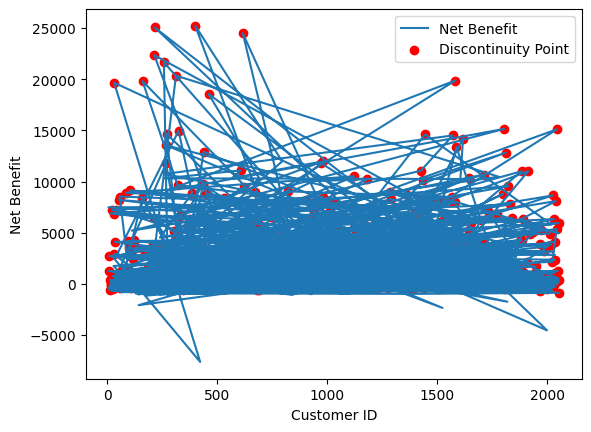

In [ ]:
import matplotlib.pyplot as plt

# Plot net benefit and potential discontinuity points
plt.plot(df['id'], df['net_benefit'], label='Net Benefit')
plt.scatter(discontinuity_points['id'], discontinuity_points['net_benefit'], color='red', label='Discontinuity Point')
plt.xlabel('Customer ID')
plt.ylabel('Net Benefit')
plt.legend()
plt.show()

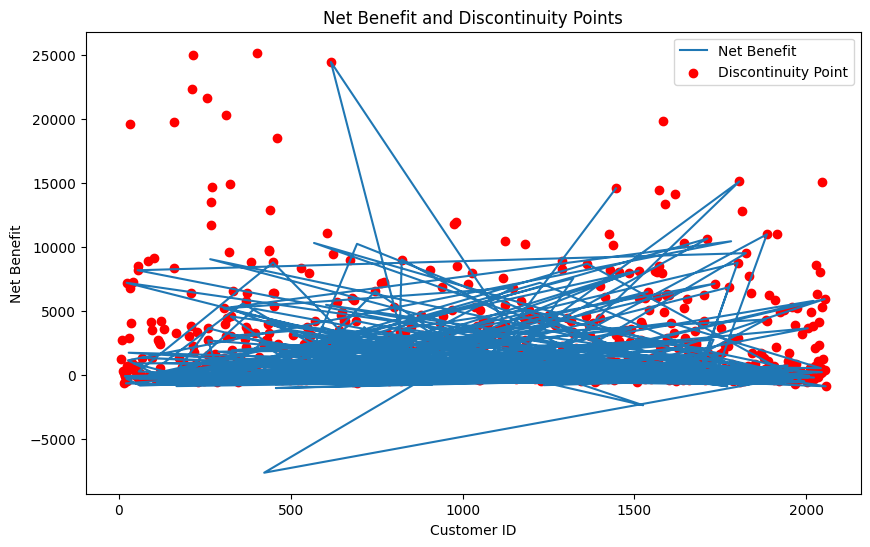

In [ ]:
import matplotlib.pyplot as plt


sampled_data = df.sample(frac=0.2)  # Adjust the fraction as needed

# Plot net benefit and potential discontinuity points for the sampled data
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(sampled_data['id'], sampled_data['net_benefit'], label='Net Benefit')
plt.scatter(
    discontinuity_points['id'],
    discontinuity_points['net_benefit'],
    color='red',
    label='Discontinuity Point'
)
plt.xlabel('Customer ID')
plt.ylabel('Net Benefit')
plt.legend()
plt.title('Net Benefit and Discontinuity Points')
plt.show()


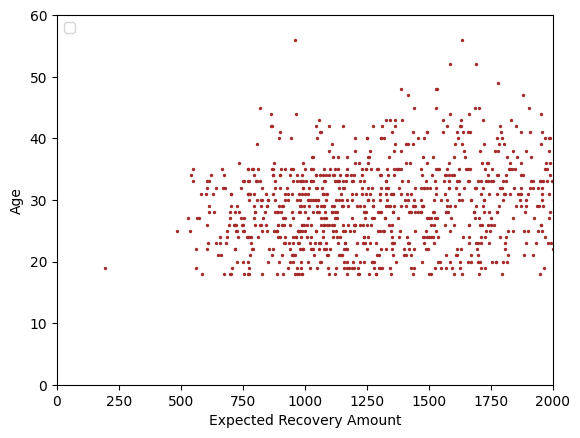

In [ ]:
# Scatterplot: Age vs Expected Recovery Amount
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(x = df['expected_recovery_amount'], y = df['age'], c = 'brown', s = 2)
plt.xlim(0, 2000) #limit exp recov amount to $2000
plt.ylim(0, 60) #to avoid non-data whitespace
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Age')
plt.legend(loc = 2)
plt.show()

In [ ]:
# Import stats module
from scipy import stats

#Compute average age just below & above threshold ($1000)
era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) &
                      (df['expected_recovery_amount']>=900)]
by_recovery_strategy = era_900_1100.groupby(['recovery_strategy'])
by_recovery_strategy['age'].describe().unstack()

# Perform Kruskal-Wallis test
Level_0_age = era_900_1100.loc[df['recovery_strategy']=="Level_0_Age"]['age']
Level_1_age = era_900_1100.loc[df['recovery_strategy']=="Level_1_Age"]['age']
stats.kruskal(Level_0_age, Level_1_age)

KruskalResult(statistic=nan, pvalue=nan)

In [ ]:
# Number of customers in each category
# Compute the crosstab of sex and recovery_strategy
crosstab = pd.crosstab(df.loc[(df['expected_recovery_amount']<1100) &
                              (df['expected_recovery_amount']>=900)]['recovery_strategy'],
                       df['sex'])
crosstab

# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print('p-val is: ', p_val)

p-val is:  0.5377947810444592


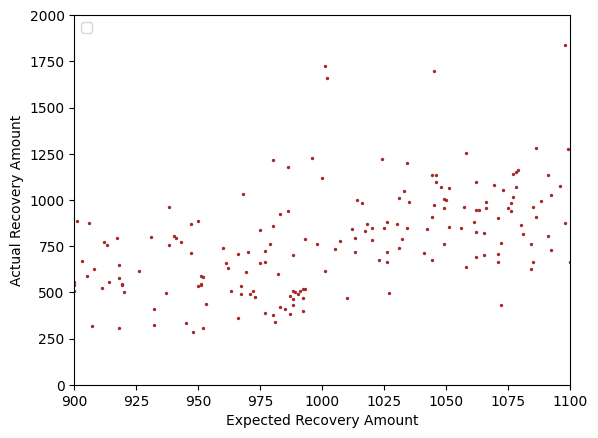

In [ ]:
# Scatterplot: Actual Recovery Amount vs Expected Recovery Amount
plt.scatter(x = df['expected_recovery_amount'], y = df['actual_recovery_amount'], c = "brown", s =2)
plt.xlim(900, 1100) #just below, just above threshold
plt.ylim(0, 2000)
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.legend(loc = 2)
plt.show()

In [ ]:
unique_levels = df['recovery_strategy'].unique()

In [ ]:
print(unique_levels)

['Level 0 Recovery' 'Level 1 Recovery' 'Level 2 Recovery'
 'Level 3 Recovery' 'Level 4 Recovery']


In [ ]:

# Define the cost increase per level
cost_increase_per_level = 50

# Create a binary variable to indicate treatment (above threshold) and control (below threshold)
df['treatment'] = np.where(df['recovery_strategy'] != unique_levels[0], 1, 0)

# Create a constant term for the regression
df['constant'] = 1

# Perform the RDD analysis using statsmodels
X = df[['constant', 'treatment']]
y = df['actual_recovery_amount']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the coefficient for the 'treatment' variable
treatment_coefficient = model.params['treatment']

# Calculate the net effect of treatment (recovery amount - cost increase)
net_effect = treatment_coefficient - cost_increase_per_level

# Print the coefficient and net effect
print("Coefficient for treatment:", treatment_coefficient)
print("Net effect of treatment (recovery amount - cost increase):", net_effect)

Coefficient for treatment: 4005.6565255707833
Net effect of treatment (recovery amount - cost increase): 3955.6565255707833
